In [1]:
# Cell 1: Imports and Setup
# ---------------------------
# Standard libraries for data manipulation and numerical operations
import numpy as np
import pandas as pd

# The powerhouse for statistical modeling and econometrics
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

# For plotting our results
import matplotlib.pyplot as plt
import seaborn as sns

# For Ridge Regression
from sklearn.linear_model import Ridge

# --- Notebook Settings ---
# Aesthethics for our plots
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
# Suppress scientific notation in pandas for better readability
pd.set_option('display.float_format', lambda x: '%.5f' % x)

print("Libraries imported successfully.")

Libraries imported successfully.


In [5]:
# Cell 2 (Corrected): Data Loading and Preparation
# ------------------------------------------------
# For this notebook, I'll assume 'prices.txt' is in the same directory
# and is a simple space-separated file without a header.
try:
    # Load the data. We DO NOT transpose it, as the data is already in the
    # correct format (rows=days, columns=assets).
    prices_df = pd.read_csv('prices.txt', header=None, delim_whitespace=True) # <-- .T REMOVED
    prices_df.columns = [f'Asset_{i}' for i in range(prices_df.shape[1])]
    print("Successfully loaded and formatted prices.txt")
    print("Shape of data:", prices_df.shape)
except FileNotFoundError:
    print("Error: 'prices.txt' not found.")
split_day = 500
train_df = prices_df.iloc[:split_day]
test_df = prices_df.iloc[split_day:]

print(f"\nData split into training and testing sets:")
print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape:   {test_df.shape}")

print("\nFirst 5 rows of the training data:")
train_df.head()

Successfully loaded and formatted prices.txt
Shape of data: (750, 50)

Data split into training and testing sets:
Training data shape: (500, 50)
Testing data shape:   (250, 50)

First 5 rows of the training data:


/var/folders/hy/drpzmvd95tx8vdvjd3gqxg500000gn/T/ipykernel_90707/1439471740.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  prices_df = pd.read_csv('prices.txt', header=None, delim_whitespace=True) # <-- .T REMOVED


,Asset_0,Asset_1,Asset_2,Asset_3,Asset_4,Asset_5,Asset_6,Asset_7,Asset_8,Asset_9,...,Asset_40,Asset_41,Asset_42,Asset_43,Asset_44,Asset_45,Asset_46,Asset_47,Asset_48,Asset_49
0,38.25000,69.06000,62.08000,31.80000,63.01000,28.30000,36.93000,43.23000,42.31000,67.37000,...,74.39000,41.30000,30.05000,39.53000,76.07000,28.62000,72.03000,24.02000,76.03000,27.50000
1,38.11000,69.98000,62.39000,31.74000,62.49000,28.23000,37.13000,42.85000,41.85000,68.41000,...,74.69000,41.70000,30.18000,38.93000,75.71000,28.47000,72.11000,24.04000,76.05000,27.54000
2,37.90000,69.56000,62.82000,31.57000,62.74000,28.60000,36.57000,42.99000,41.48000,69.84000,...,75.14000,41.14000,30.09000,38.17000,75.56000,28.48000,72.54000,23.76000,75.66000,27.55000
3,37.64000,69.39000,63.26000,31.56000,61.85000,28.67000,37.09000,43.23000,41.24000,70.36000,...,75.24000,41.38000,30.08000,38.24000,75.35000,28.59000,73.75000,23.97000,75.71000,27.74000
4,37.70000,69.71000,64.04000,31.42000,62.02000,28.42000,37.09000,42.90000,41.40000,69.12000,...,75.33000,41.69000,30.34000,37.85000,75.21000,28.55000,74.32000,24.01000,75.77000,27.54000


In [9]:
# Cell 3 (Updated): Finding Non-Overlapping Cointegrated Pairs
# -------------------------------------------------------------

def find_cointegrated_pairs(data):
    """
    Finds the best set of non-overlapping cointegrated pairs.
    
    Args:
        data (pd.DataFrame): DataFrame where rows are time and columns are asset prices.
        
    Returns:
        pd.DataFrame: A DataFrame containing the best, mutually exclusive cointegrated pairs,
                      sorted by their p-value.
    """
    n_assets = data.shape[1]
    all_pairs = []
    
    # --- Step 1: Find all cointegrated pairs and their p-values ---
    print("Step 1: Testing all unique pairs for cointegration...")
    for i in range(n_assets):
        for j in range(i + 1, n_assets):
            asset1 = data.columns[i]
            asset2 = data.columns[j]
            
            # Test for cointegration
            result = coint(data[asset1], data[asset2])
            pvalue = result[1]
            
            # We only consider pairs that have some statistical significance
            if pvalue < 0.05:
                all_pairs.append((asset1, asset2, pvalue))
    
    # --- Step 2: Sort pairs by p-value (most significant first) ---
    sorted_pairs = sorted(all_pairs, key=lambda x: x[2])
    print(f"Step 2: Found {len(sorted_pairs)} potentially significant pairs.")

    # --- Step 3: Filter for non-overlapping pairs ---
    # We iterate through the sorted list and pick the best pair for an asset.
    # Once an asset is in a pair, we don't use it again.
    final_non_overlapping_pairs = []
    used_assets = set()
    
    for asset1, asset2, pvalue in sorted_pairs:
        # Check if either asset has already been used in a "better" pair
        if asset1 not in used_assets and asset2 not in used_assets:
            final_non_overlapping_pairs.append((asset1, asset2, pvalue))
            # Mark these assets as used
            used_assets.add(asset1)
            used_assets.add(asset2)
            
    print("Step 3: Filtered down to the best non-overlapping pairs.")
                
    # Create a nice DataFrame for the results
    results_df = pd.DataFrame(final_non_overlapping_pairs, columns=['Asset 1', 'Asset 2', 'P-Value'])
    return results_df

# --- Find cointegrated pairs ONLY on the training data ---
print("Searching for the best set of non-overlapping pairs on the TRAINING data...")
final_pairs_df = find_cointegrated_pairs(train_df)

print(f"\nFound {len(final_pairs_df)} mutually exclusive cointegrated pairs.")
print("Final list of pairs to be used in the strategy:")
print(final_pairs_df)

Searching for the best set of non-overlapping pairs on the TRAINING data...
Step 1: Testing all unique pairs for cointegration...
Step 2: Found 91 potentially significant pairs.
Step 3: Filtered down to the best non-overlapping pairs.

Found 12 mutually exclusive cointegrated pairs.
Final list of pairs to be used in the strategy:
     Asset 1   Asset 2  P-Value
0    Asset_3   Asset_4  0.00036
1   Asset_48  Asset_49  0.00096
2   Asset_11  Asset_17  0.00509
3   Asset_33  Asset_35  0.00567
4    Asset_6  Asset_23  0.00578
5    Asset_7  Asset_47  0.00605
6   Asset_18  Asset_38  0.00737
7    Asset_8  Asset_31  0.01453
8   Asset_29  Asset_43  0.01875
9   Asset_26  Asset_46  0.01990
10   Asset_0  Asset_39  0.02924
11  Asset_15  Asset_24  0.03140


Analyzing the pair: ('Asset_3', 'Asset_4')

--- 1. Ordinary Least Squares (OLS) ---
Hedge Ratio (beta): -0.4910
Intercept (alpha): 61.7705

OLS Model Summary:
                            OLS Regression Results                            
Dep. Variable:                Asset_3   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     2474.
Date:                Fri, 27 Jun 2025   Prob (F-statistic):          2.63e-195
Time:                        11:07:11   Log-Likelihood:                -704.38
No. Observations:                 500   AIC:                             1413.
Df Residuals:                     498   BIC:                             1421.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>

/var/folders/hy/drpzmvd95tx8vdvjd3gqxg500000gn/T/ipykernel_90707/2869097671.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio_ols = model_ols.params[1]
/var/folders/hy/drpzmvd95tx8vdvjd3gqxg500000gn/T/ipykernel_90707/2869097671.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Intercept (alpha): {model_ols.params[0]:.4f}")


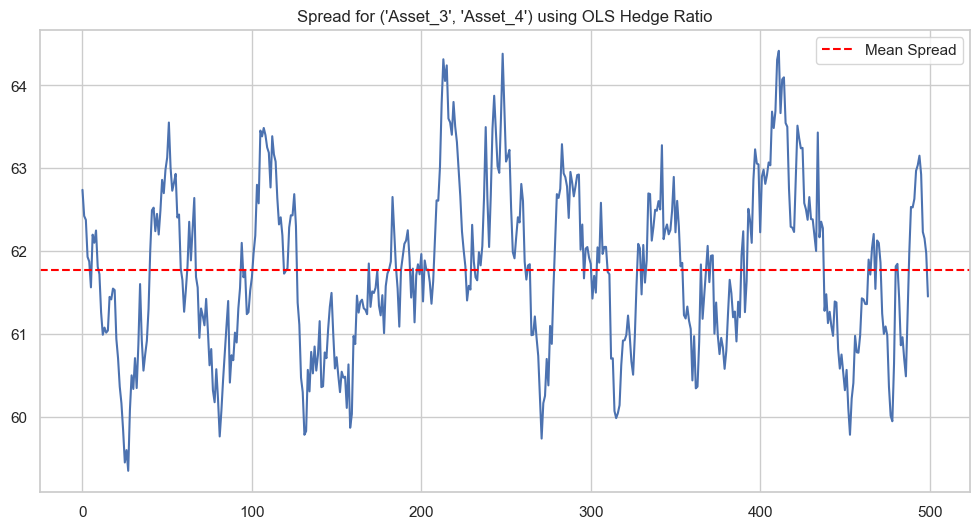

In [10]:
# Cell 4: Analyzing a Single Pair with OLS
# ----------------------------------------

# Let's pick the top pair from our search (or a specific one for demonstration)
if not cointegrated_pairs_df.empty:
    selected_pair = (cointegrated_pairs_df['Asset 1'][0], cointegrated_pairs_df['Asset 2'][0])
else:
    # Fallback if no pairs were found
    selected_pair = ('Asset_48', 'Asset_49') 
    print("Warning: No cointegrated pairs found. Using a fallback pair for demonstration.")
    
print(f"Analyzing the pair: {selected_pair}")

# Define our dependent (y) and independent (x) variables for the regression
y = train_df[selected_pair[0]]
x = train_df[selected_pair[1]]

# Add a constant (intercept) to the independent variable. This is crucial.
# The intercept represents the long-term mean of the spread.
x_with_const = sm.add_constant(x)

# 1. --- Standard OLS ---
print("\n--- 1. Ordinary Least Squares (OLS) ---")
model_ols = sm.OLS(y, x_with_const).fit()
hedge_ratio_ols = model_ols.params[1]

print(f"Hedge Ratio (beta): {hedge_ratio_ols:.4f}")
print(f"Intercept (alpha): {model_ols.params[0]:.4f}")

# The OLS summary is a treasure trove of information.
print("\nOLS Model Summary:")
print(model_ols.summary())

# Let's analyze the residuals (the spread)
spread_ols = y - hedge_ratio_ols * x
spread_ols.plot(title=f"Spread for {selected_pair} using OLS Hedge Ratio")
plt.axhline(spread_ols.mean(), color='red', linestyle='--', label='Mean Spread')
plt.legend()
plt.show()

# Key things to check in the OLS summary:
# - p-value of the hedge ratio (P>|t|): Should be very low (e.g., < 0.05) for significance.
# - R-squared: How much of y's variance is explained by x. Higher is better.
# - Durbin-Watson: Tests for autocorrelation in the residuals. A value around 2.0 is good.
#   Values < 1.5 or > 2.5 suggest autocorrelation, which violates an OLS assumption.

In [8]:
# Cell 5: Addressing OLS Shortcomings - HAC and Ridge
# -------------------------------------------------

# If the Durbin-Watson stat from the OLS summary was far from 2.0, our standard errors
# (and thus p-values) might be unreliable. We can use HAC (Heteroskedasticity and
# Autocorrelation Consistent) standard errors, also known as Newey-West errors.

# 2. --- OLS with HAC (Newey-West) Standard Errors ---
print("\n--- 2. OLS with HAC (Newey-West) Standard Errors ---")
# Note: The coefficients (hedge ratio) will be identical to OLS.
# What changes are the standard errors, t-stats, and p-values to be more reliable.
model_hac = sm.OLS(y, x_with_const).fit(cov_type='HAC', cov_kwds={'maxlags': 10}) # maxlags can be tuned
hedge_ratio_hac = model_hac.params[1]

print(f"Hedge Ratio (beta): {hedge_ratio_hac:.4f} (Same as OLS)")
print("\nHAC Model Summary:")
print(model_hac.summary())
print("\nCompare the 'Std Err', 't', and 'P>|t|' columns with the OLS summary above.")
print("These are now robust to autocorrelation.")


# 3. --- Ridge Regression ---
# Ridge is useful for regularization, especially to prevent overfitting if you suspect
# your model is too complex or your predictors are highly correlated (not an issue here
# with one predictor, but good to know). It adds a penalty for large coefficients.
print("\n--- 3. Ridge Regression ---")

# sklearn's Ridge model
model_ridge = Ridge(alpha=1.0) # alpha is the regularization strength, needs to be tuned
model_ridge.fit(x.values.reshape(-1, 1), y.values)

hedge_ratio_ridge = model_ridge.coef_[0]
print(f"Hedge Ratio (beta) from Ridge (alpha=1.0): {hedge_ratio_ridge:.4f}")
print("Note: Ridge is less about statistical significance and more about predictive accuracy and robustness.")
print("It's a different tool for a different job, but can be useful for finding stable hedge ratios.")


--- 2. OLS with HAC (Newey-West) Standard Errors ---
Hedge Ratio (beta): -0.4910 (Same as OLS)

HAC Model Summary:
                            OLS Regression Results                            
Dep. Variable:                Asset_3   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     325.2
Date:                Fri, 27 Jun 2025   Prob (F-statistic):           2.50e-56
Time:                        11:02:48   Log-Likelihood:                -704.38
No. Observations:                 500   AIC:                             1413.
Df Residuals:                     498   BIC:                             1421.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------

/var/folders/hy/drpzmvd95tx8vdvjd3gqxg500000gn/T/ipykernel_90707/1412376191.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio_hac = model_hac.params[1]


Calculating rolling hedge ratio for ('Asset_3', 'Asset_4') with window size 85...
Calculation complete.


/var/folders/hy/drpzmvd95tx8vdvjd3gqxg500000gn/T/ipykernel_90707/3244222576.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]
/var/folders/hy/drpzmvd95tx8vdvjd3gqxg500000gn/T/ipykernel_90707/3244222576.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]
/var/folders/hy/drpzmvd95tx8vdvjd3gqxg500000gn/T/ipykernel_90707/3244222576.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.il

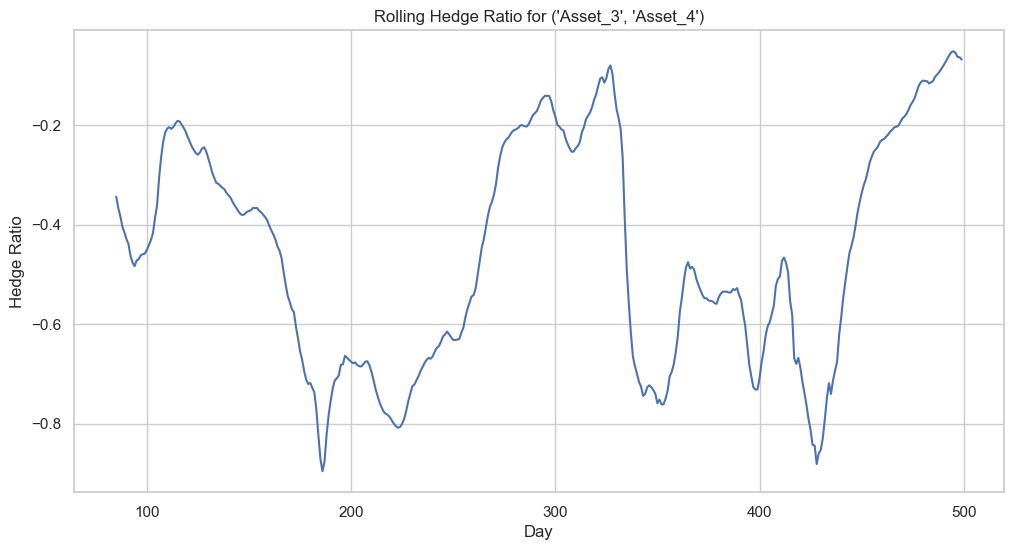

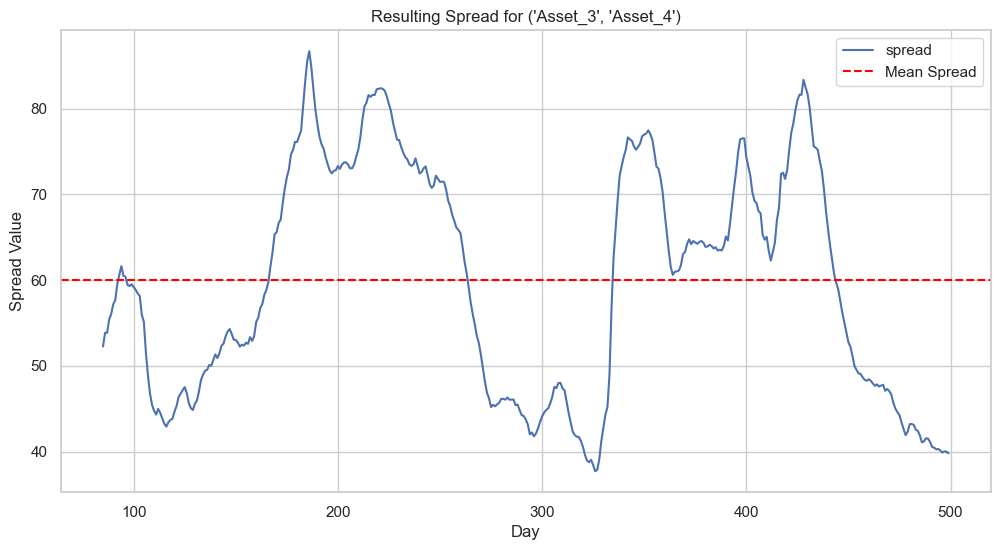


Last 5 calculated values:
           hedge_ratio   spread
timestamp                      
495           -0.05102 40.12402
496           -0.05437 39.88263
497           -0.06263 40.00746
498           -0.06311 39.99194
499           -0.06762 39.79807


In [11]:
# Cell 6: Rolling Hedge Ratio Calculation
# ---------------------------------------

def calculate_rolling_hedge_ratio(data, pair, window_size):
    """
    Calculates the hedge ratio and spread over time using a rolling window.

    Args:
        data (pd.DataFrame): The price data (ideally the training set).
        pair (tuple): A tuple containing the names of the two assets.
        window_size (int): The size of the rolling window for the regression.

    Returns:
        pd.DataFrame: A DataFrame containing the rolling hedge ratio and the calculated spread.
    """
    asset1, asset2 = pair[0], pair[1]
    
    # We need at least 'window_size' data points to start.
    # The loop will iterate through the DataFrame, calculating the hedge ratio at each step.
    # We will store the results in a list of dictionaries.
    results = []

    print(f"Calculating rolling hedge ratio for {pair} with window size {window_size}...")

    for t in range(window_size, len(data)):
        # Define the current window of data
        window = data.iloc[t - window_size:t]
        
        # Get the price series for the pair within this window
        y = window[asset1]
        x = window[asset2]
        
        # --- Perform the regression for the current window ---
        # We use the robust HAC model as discussed before.
        x_with_const = sm.add_constant(x)
        model = sm.OLS(y, x_with_const).fit(cov_type='HAC', cov_kwds={'maxlags': 1})
        
        hedge_ratio = model.params[1]
        
        # --- Calculate the spread using the NEWLY calculated hedge ratio ---
        # The spread for day 't' is based on the prices at 't' and the hedge ratio
        # calculated from the window *before* 't'. This prevents look-ahead bias.
        current_price_y = data[asset1].iloc[t]
        current_price_x = data[asset2].iloc[t]
        spread = current_price_y - hedge_ratio * current_price_x
        
        results.append({
            'timestamp': data.index[t],
            'hedge_ratio': hedge_ratio,
            'spread': spread
        })

    print("Calculation complete.")
    return pd.DataFrame(results).set_index('timestamp')

# --- Let's run it on our top pair from the training set ---
if not final_pairs_df.empty:
    # Select the top pair we identified in the previous step
    top_pair = (final_pairs_df['Asset 1'].iloc[0], final_pairs_df['Asset 2'].iloc[0])
    
    # Define the lookback period for the OLS regression
    # This is a key parameter we can tune later. Let's start with your value.
    LOOKBACK_DAYS_REGRESSION = 85 

    # Calculate the rolling metrics
    rolling_results_df = calculate_rolling_hedge_ratio(
        data=train_df, 
        pair=top_pair, 
        window_size=LOOKBACK_DAYS_REGRESSION
    )

    # --- Visualize the results ---
    # 1. Plot the hedge ratio over time
    rolling_results_df['hedge_ratio'].plot(title=f'Rolling Hedge Ratio for {top_pair}')
    plt.xlabel('Day')
    plt.ylabel('Hedge Ratio')
    plt.show()

    # 2. Plot the resulting spread over time
    rolling_results_df['spread'].plot(title=f'Resulting Spread for {top_pair}')
    plt.axhline(rolling_results_df['spread'].mean(), color='red', linestyle='--', label='Mean Spread')
    plt.legend()
    plt.xlabel('Day')
    plt.ylabel('Spread Value')
    plt.show()

    print("\nLast 5 calculated values:")
    print(rolling_results_df.tail())

else:
    print("Cannot perform rolling calculation because no cointegrated pairs were found.")

Backtest Results:
  - Mean Daily PnL: -0.31242
  - Std Dev Daily PnL: 0.92795
  - Performance Score: -0.40521


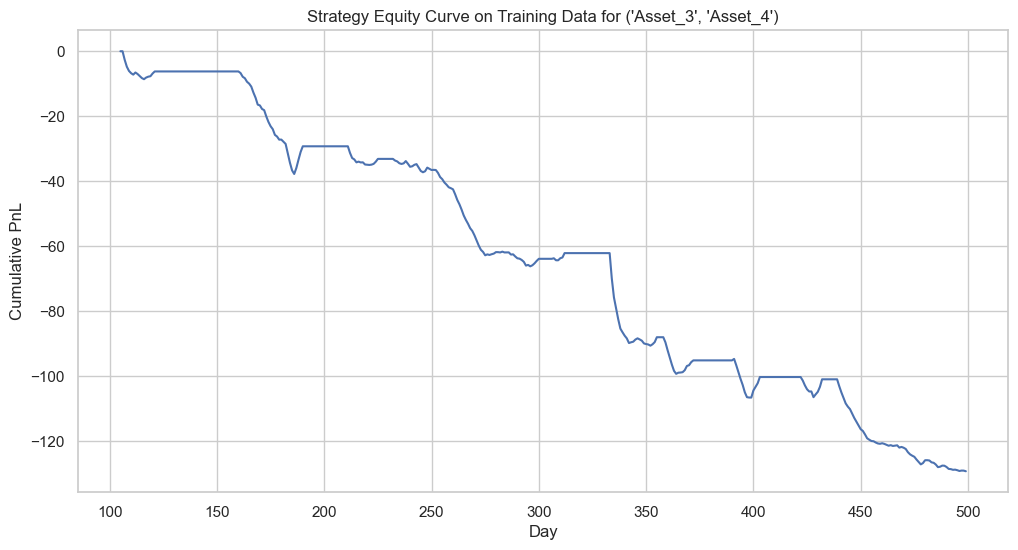

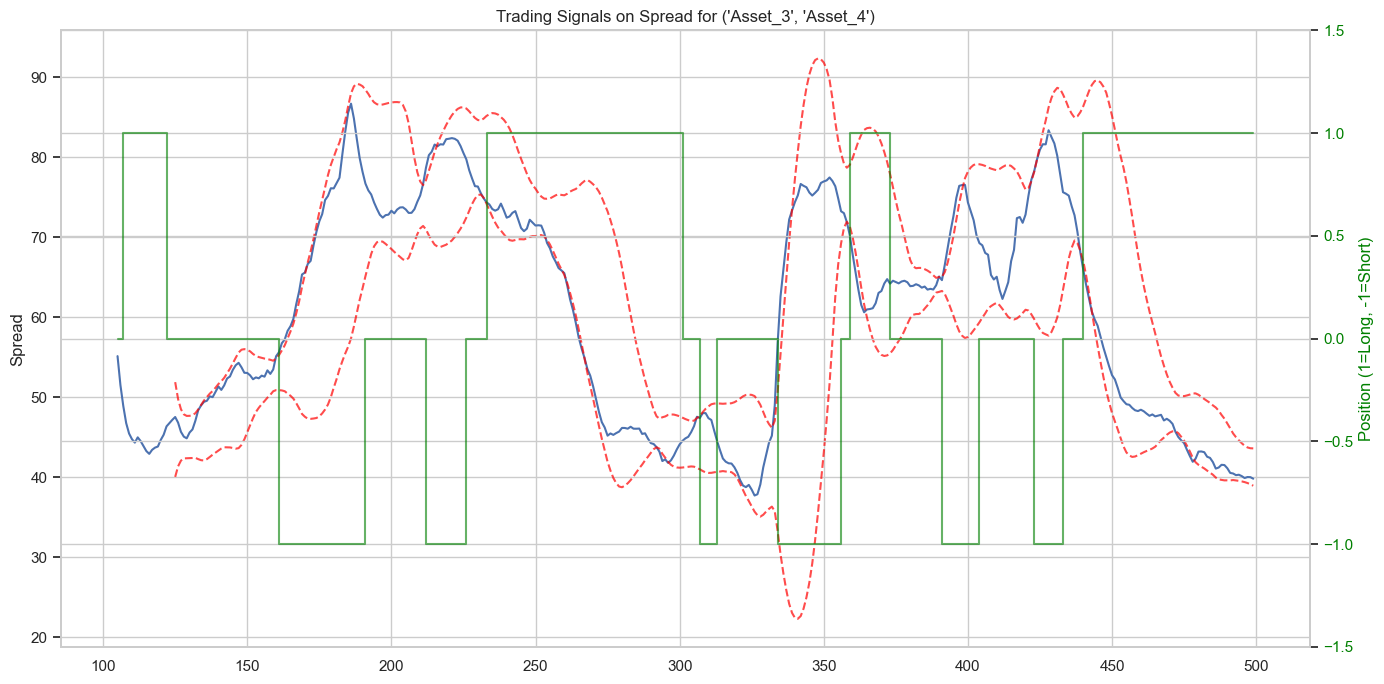

In [14]:
# Cell 7: Backtesting Engine and Initial Performance
# --------------------------------------------------

def run_strategy_backtest(spread_series, z_lookback, z_entry, z_exit):
    """
    Runs a backtest on a given spread series using a Z-score strategy.

    Args:
        spread_series (pd.Series): The time series of the pair's spread.
        z_lookback (int): The lookback window for calculating the Z-score.
        z_entry (float): The Z-score threshold for entering a position.
        z_exit (float): The Z-score threshold for exiting a position.

    Returns:
        pd.DataFrame: A DataFrame containing signals, PnL, and performance metrics.
    """
    # --- 1. Calculate Z-Score ---
    # Calculate the rolling mean and std deviation of the spread
    rolling_mean = spread_series.rolling(window=z_lookback).mean()
    rolling_std = spread_series.rolling(window=z_lookback).std()

    # Calculate the Z-score
    z_score = (spread_series - rolling_mean) / rolling_std

    # --- 2. Generate Trading Signals ---
    # We'll use a simple signal generation scheme: +1 for long, -1 for short, 0 for flat
    signals = pd.Series(index=spread_series.index, data=0)
    position = 0
    for i in range(len(spread_series)):
        if position == 0: # If we have no position
            if z_score.iloc[i] > z_entry:
                position = -1 # Short the spread
            elif z_score.iloc[i] < -z_entry:
                position = 1 # Long the spread
        else: # If we have a position
            # Exit if it reverts to the mean
            if position == -1 and z_score.iloc[i] < z_exit:
                position = 0 # Exit short position
            elif position == 1 and z_score.iloc[i] > -z_exit:
                position = 0 # Exit long position
        signals.iloc[i] = position
        
    # The positions are taken at the close of day 'i', so PnL is realized from i to i+1
    # We shift the signals by 1 to represent holding the position for the next day's return
    positions = signals.shift(1).fillna(0)

    # --- 3. Calculate PnL ---
    # The PnL is the daily change in the spread, multiplied by our position
    daily_pnl = positions * spread_series.diff()
    cumulative_pnl = daily_pnl.cumsum()

    # --- 4. Calculate Performance Score ---
    mean_pnl = daily_pnl.mean()
    std_pnl = daily_pnl.std()
    score = mean_pnl - 0.1 * std_pnl

    print(f"Backtest Results:")
    print(f"  - Mean Daily PnL: {mean_pnl:.5f}")
    print(f"  - Std Dev Daily PnL: {std_pnl:.5f}")
    print(f"  - Performance Score: {score:.5f}")

    # Combine everything into a single DataFrame for analysis
    backtest_df = pd.DataFrame({
        'Spread': spread_series,
        'Z_Score': z_score,
        'Position': positions,
        'Daily_PnL': daily_pnl,
        'Cumulative_PnL': cumulative_pnl
    }).dropna()
    
    return backtest_df, score

# --- Run the backtest with some initial parameters ---
if 'rolling_results_df' in locals():
    # These are the parameters we will optimize later
    Z_LOOKBACK = 21   # Lookback for Z-score calculation (e.g., 1 month)
    Z_ENTRY_THRESH = 2.0  # Enter when Z-score exceeds 2.0
    Z_EXIT_THRESH = 0.5   # Exit when Z-score gets close to the mean

    backtest_results, initial_score = run_strategy_backtest(
        spread_series=rolling_results_df['spread'],
        z_lookback=Z_LOOKBACK,
        z_entry=Z_ENTRY_THRESH,
        z_exit=Z_EXIT_THRESH
    )

    # --- Visualize the Backtest ---
    # 1. Plot the cumulative PnL (the "equity curve")
    backtest_results['Cumulative_PnL'].plot(title=f'Strategy Equity Curve on Training Data for {top_pair}')
    plt.xlabel('Day')
    plt.ylabel('Cumulative PnL')
    plt.show()

    # 2. Plot the spread and the trading signals
    fig, ax1 = plt.subplots(figsize=(14, 7))
    
    # Plot spread and Z-score bands
    ax1.plot(backtest_results['Spread'], label='Spread')
    ax1.set_ylabel('Spread')
    ax1.set_title(f'Trading Signals on Spread for {top_pair}')
    
    # Add entry/exit bands to the plot for context
    z_bands = pd.DataFrame(index=backtest_results.index)
    z_bands['upper_entry'] = (backtest_results['Z_Score'] * 0 + Z_ENTRY_THRESH) * backtest_results['Spread'].rolling(Z_LOOKBACK).std() + backtest_results['Spread'].rolling(Z_LOOKBACK).mean()
    z_bands['lower_entry'] = (backtest_results['Z_Score'] * 0 - Z_ENTRY_THRESH) * backtest_results['Spread'].rolling(Z_LOOKBACK).std() + backtest_results['Spread'].rolling(Z_LOOKBACK).mean()
    ax1.plot(z_bands['upper_entry'], color='red', linestyle='--', alpha=0.7, label='Entry Threshold')
    ax1.plot(z_bands['lower_entry'], color='red', linestyle='--', alpha=0.7)
    
    # Plot positions on a second y-axis
    ax2 = ax1.twinx()
    ax2.plot(backtest_results['Position'], drawstyle='steps-post', color='green', alpha=0.6, label='Position')
    ax2.set_ylabel('Position (1=Long, -1=Short)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.set_ylim([-1.5, 1.5])
    
    fig.tight_layout()
    plt.show()

else:
    print("Cannot run backtest because rolling results were not calculated.")

In [15]:
# Cell 8: Grid Search for Optimal Strategy Parameters
# ---------------------------------------------------
import itertools
import pandas as pd

# This can take a moment, so let's keep the ranges reasonable for a first pass.
# We can refine them later if needed.
param_grid = {
    'z_lookback': [10, 21, 42, 63], # Approx half-month, 1 month, 2 months, 3 months
    'z_entry': [1.0, 1.5, 2.0, 2.5, 3.0],
    'z_exit': [0.0, 0.5, 1.0]
}

# Generate all possible combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
print(f"Starting grid search. Testing {len(all_params)} parameter combinations...")

results_list = []

# --- Loop through all parameter combinations ---
for i, params in enumerate(all_params):
    # We add a try-except block to handle cases where a parameter set might fail
    # (e.g., not enough data for a long lookback, though unlikely with this setup)
    try:
        # Run the backtest function from the previous cell with the current parameter set
        backtest_df, score = run_strategy_backtest(
            spread_series=rolling_results_df['spread'],
            z_lookback=params['z_lookback'],
            z_entry=params['z_entry'],
            z_exit=params['z_exit']
        )
        
        # Store the results
        results_list.append({
            'z_lookback': params['z_lookback'],
            'z_entry': params['z_entry'],
            'z_exit': params['z_exit'],
            'score': score
        })
        print(f"  {i+1}/{len(all_params)}: {params} -> Score: {score:.4f}")

    except Exception as e:
        print(f"  {i+1}/{len(all_params)}: {params} -> Failed with error: {e}")


# --- Analyze the results of the grid search ---
grid_search_results_df = pd.DataFrame(results_list)

# Sort the results by score in descending order to find the best
best_params_df = grid_search_results_df.sort_values(by='score', ascending=False)

print("\n--- Grid Search Complete ---")
print("\nTop 5 Best Performing Parameter Sets on Training Data:")
print(best_params_df.head(5))

# Extract the best parameter set
if not best_params_df.empty:
    best_params = best_params_df.iloc[0].to_dict()
    print("\nOptimal parameters found:")
    print(best_params)
else:
    print("\nGrid search did not yield any valid results.")

Starting grid search. Testing 60 parameter combinations...
Backtest Results:
  - Mean Daily PnL: -0.47105
  - Std Dev Daily PnL: 1.03125
  - Performance Score: -0.57417
  1/60: {'z_lookback': 10, 'z_entry': 1.0, 'z_exit': 0.0} -> Score: -0.5742
Backtest Results:
  - Mean Daily PnL: -0.50135
  - Std Dev Daily PnL: 0.98189
  - Performance Score: -0.59953
  2/60: {'z_lookback': 10, 'z_entry': 1.0, 'z_exit': 0.5} -> Score: -0.5995
Backtest Results:
  - Mean Daily PnL: -0.51949
  - Std Dev Daily PnL: 0.95585
  - Performance Score: -0.61508
  3/60: {'z_lookback': 10, 'z_entry': 1.0, 'z_exit': 1.0} -> Score: -0.6151
Backtest Results:
  - Mean Daily PnL: -0.46622
  - Std Dev Daily PnL: 1.01834
  - Performance Score: -0.56805
  4/60: {'z_lookback': 10, 'z_entry': 1.5, 'z_exit': 0.0} -> Score: -0.5681
Backtest Results:
  - Mean Daily PnL: -0.48539
  - Std Dev Daily PnL: 0.97420
  - Performance Score: -0.58281
  5/60: {'z_lookback': 10, 'z_entry': 1.5, 'z_exit': 0.5} -> Score: -0.5828
Backtest Re